# CFPB Text Classification with Transformers
11/18/2022

Text classification on the Consumer Financial Protection Bureau (CFPB) Consumer Financial Complaints Database.
Two large language model (LLM) classifiers using the HuggingFace transformers library: The distilled BERT transformer (*DistilBERT*) and a BERT transformer fine-tuned to financial texts by ProsusAI (*FinBERT*).

* andescon2022_cfpb_classify_transformers.ipynb


## IEEE ANDESCON 2022

IEEE Andean Conference: Technology and innovation, Barranquilla-Colombia, September 16-19, 2022

* https://nelscorrea.github.io/andescon2022


In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn

import datasets as hfds
import transformers as hf
import tensorflow as tf

import copy, gzip, os, re, sys
from datetime import datetime

import cfpb as cfpb
import model_utils as mu

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
warnings.filterwarnings("ignore")

In [2]:
print(f"NumPy {np.__version__}, pandas {pd.__version__}, sklearn {sklearn.__version__}")
print(f"HuggingFace Transformers: {hf.__version__}, Datasets: {hfds.__version__}")
print(f"TensorFlow: {tf.__version__}, Keras: {tf.keras.__version__}")

NumPy 1.22.0, pandas 1.4.3, sklearn 1.1.1
HuggingFace Transformers: 4.11.3, Datasets: 1.16.1
TensorFlow: 2.9.1, Keras: 2.9.0


<hr/>

# <a id="toc">Contents - CFPB Text Classification with Transformers</a>

* [CFPB Consumer Financial Complaints Database](#cfpb-ccd)
* [DistilBERT Transformer Model](#distilbert)
* [FinBERT Transformer Model](#finbert)
* [Performance with transformers](#performance)
* [Dense feature visualization](#visualization)
    

Other models considered: See [Baselines](andescon2022_cfpb_classify_baselines.ipynb) notebook.


In [3]:
# Get CFPB data
remote_data_uri = "https://github.com/nelscorrea/datasets/raw/main/cfpb/consumer_complaints.csv.gz"
get_cfpb_data = False  # set to True to download data from remote_data_uri
if get_cfpb_data:
    !wget -Pdata $remote_data_uri
else:
    print("CFPB dataset not downloaded: assumed in ./data\n")
!ls -la data

CFPB dataset not downloaded: assumed in ./data

total 416664
drwxr-xr-x   4 nelson  staff        128 Feb 20 12:28 .
drwxr-xr-x  31 nelson  staff        992 Feb 21 16:05 ..
-rw-r--r--   1 nelson  staff  175385569 Dec 16 02:29 consumer_complaints.csv
-rw-r--r--   1 nelson  staff   37943046 Dec 16 02:29 consumer_complaints.csv.gz


In [4]:
# CFPB CSV or JSON files
cfpb_base = "data/"       # local data directory
cfpb_kaggle_csv_fn = "consumer_complaints.csv"
cfpb_kaggle_csv_fn = "consumer_complaints.csv.gz" # compressed file
fin_path = os.path.join(cfpb_base, cfpb_kaggle_csv_fn)

# All CFPB columns
cfpb_ccd_columns = ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 
                    'consumer_complaint_narrative', 'company_public_response', 'company', 
                    'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 
                    'date_sent_to_company', 'company_response_to_consumer',  
                    'timely_response', 'consumer_disputed?', 'complaint_id']
# CFPB wanted columns
cfpb_columns_tcs = ['date_received', 'product', 'issue', 'company', 'state', 'zipcode', 
                    'consumer_complaint_narrative', 'complaint_id']

# Dataset split percentages to use
s0, s1, s2, s3 = [0, 90, 5, 5] # Full cfpb_dataset_split dataset to use (100%): %start, %train, %val, %test
# s0, s1, s2, s3 = [89, 90, 1, 1] # Small dataset to use for dev/test (3%): only 1% of data for train/val/test

split={"train":f"cfpb_ccd[{s0}:{s1}%]", 
       "validation":f"cfpb_ccd[{s1}%:{s1+s2}%]","test":f"cfpb_ccd[{s1+s2}%:{s1+s2+s3}%]"}

# Load as HuggingFace dataset
# skiprows=1, # Not supported in hfds.load_dataset() - to remove header filter first row below as needed
print(f"Reading cfpb_ds from: {fin_path}") # use fin_path
cfpb_ds = hfds.load_dataset(
    "csv", data_files={'cfpb_ccd':[fin_path]}, sep=",", split=split, names=cfpb_ccd_columns
)

print(f"cfpb_ds.shape: {cfpb_ds.shape}")
print(f"cfpb_ds splits - train: {s0}-{s1}%, validation: {s2}%, test: {s3}%\n")
cfpb_ds

Reading cfpb_ds from: data/consumer_complaints.csv.gz


Using custom data configuration default-950eba856d48b1ea
Reusing dataset csv (/Users/nelson/.cache/huggingface/datasets/csv/default-950eba856d48b1ea/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/3 [00:00<?, ?it/s]

cfpb_ds.shape: {'train': (500362, 18), 'validation': (27798, 18), 'test': (27798, 18)}
cfpb_ds splits - train: 0-90%, validation: 5%, test: 5%



DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'],
        num_rows: 500362
    })
    validation: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'],
        num_rows: 27798
    })
    test: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode'

In [5]:
# Null narratives in dataset splits: None in filtered_consumer_complaints.csv
splits = ["train", "validation", "test"]
narratives = {split:cfpb_ds[split]["consumer_complaint_narrative"] for split in splits}
cfpb_ds_rows = {split:cfpb_ds[split].num_rows for split in splits}
narratives_not_null = {split:len([x for x in narratives[split] if x != None]) for split in splits}
print(f"       cfpb_ds rows: {cfpb_ds_rows}")
print(f"narratives_not_null: {narratives_not_null}\n")

       cfpb_ds rows: {'train': 500362, 'validation': 27798, 'test': 27798}
narratives_not_null: {'train': 52586, 'validation': 8718, 'test': 5503}



In [6]:
# Dataset filters
# first row in cfpb_ds["train"] only
print(f"Total source rows (before filter): {np.sum([i for i in cfpb_ds.num_rows.values()]):,d}")
apply_filters = True  # False to skip filters
if apply_filters:
    cfpb_ds = cfpb_ds.filter(
        lambda x: (x["consumer_complaint_narrative"] != "consumer_complaint_narrative")
    )

    # Filter out null narratives
    print(f"Total rows (source): {np.sum([i for i in cfpb_ds.num_rows.values()]):,d}")
    cfpb_ds = cfpb_ds.filter(
        lambda x: (x["consumer_complaint_narrative"] != None and x["product"] != None)
    )

print(f"Total rows (after filter): {np.sum([i for i in cfpb_ds.num_rows.values()]):,d}")
print(f"   cfpb_ds.shape (after filter): {cfpb_ds.shape}")
# cfpb_ds

Parameter 'function'=<function <lambda> at 0x7f95c077a3a0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Total source rows (before filter): 555,958


  0%|          | 0/501 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

Total rows (source): 555,957


  0%|          | 0/501 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

Total rows (after filter): 66,806
   cfpb_ds.shape (after filter): {'train': (52585, 18), 'validation': (8718, 18), 'test': (5503, 18)}


In [7]:
# Drop unwanted columns
print(f"cfpb_ds.shape (source): {cfpb_ds.shape}")
columns_to_remove = set(cfpb_columns_tcs).symmetric_difference(cfpb_ccd_columns)
cfpb_ds = cfpb_ds.remove_columns(columns_to_remove)
print(f"cfpb_ds.shape (after): {cfpb_ds.shape}")
# cfpb_ds

cfpb_ds.shape (source): {'train': (52585, 18), 'validation': (8718, 18), 'test': (5503, 18)}
cfpb_ds.shape (after): {'train': (52585, 8), 'validation': (8718, 8), 'test': (5503, 8)}


In [8]:
# Labels: product, issue
cfpb_product_names = np.unique([p for p in cfpb_ds["train"]["product"]])
cfpb_issue_names = np.unique([p for p in cfpb_ds["train"]["issue"]])

cfpb_product_label2int = {l:i for i, l in enumerate(cfpb_product_names)}
cfpb_issue_label2int = {l:i for i, l in enumerate(cfpb_issue_names)}

print(f"cfpb_product_names: {len(cfpb_product_names)}, cfpb_issue_names: {len(cfpb_issue_names)}")
cfpb_product_label2int 

cfpb_product_names: 11, cfpb_issue_names: 90


{'Bank account or service': 0,
 'Consumer Loan': 1,
 'Credit card': 2,
 'Credit reporting': 3,
 'Debt collection': 4,
 'Money transfers': 5,
 'Mortgage': 6,
 'Other financial service': 7,
 'Payday loan': 8,
 'Prepaid card': 9,
 'Student loan': 10}

In [9]:
# Add pid, wc - product label ids and word counts
for split in splits:
    cfpb_ds[split] = cfpb_ds[split].map(lambda r: {"pid":cfpb_product_label2int[r["product"]]})
    cfpb_ds[split] = cfpb_ds[split].map(lambda r: {"wc":len(str.split(r["consumer_complaint_narrative"]))})

cfpb_ccd_columns += ['pid', 'wc']
cfpb_columns_tcs += ['pid', 'wc']
cfpb_ds #["train"]

  0%|          | 0/52585 [00:00<?, ?ex/s]

  0%|          | 0/52585 [00:00<?, ?ex/s]

  0%|          | 0/8718 [00:00<?, ?ex/s]

  0%|          | 0/8718 [00:00<?, ?ex/s]

  0%|          | 0/5503 [00:00<?, ?ex/s]

  0%|          | 0/5503 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc'],
        num_rows: 52585
    })
    validation: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc'],
        num_rows: 8718
    })
    test: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc'],
        num_rows: 5503
    })
})

In [10]:
# As pandas
cfpb_ds.set_format("pandas")
cfpb_train_df = cfpb_ds[splits[0]][:]  # "train" split
cfpb_ds.reset_format() # Reset format

print(f"cfpb_train_df.shape: {cfpb_train_df.shape}")
cfpb_train_df[cfpb_columns_tcs].head()

cfpb_train_df.shape: (52585, 10)


,date_received,product,issue,company,state,zipcode,consumer_complaint_narrative,complaint_id,pid,wc
0,03/19/2015,Debt collection,Cont'd attempts collect debt not owed,"Diversified Consultants, Inc.",NY,121XX,XXXX has claimed I owe them {$27.00} for XXXX ...,1290516,4,55
1,03/19/2015,Consumer Loan,Managing the loan or lease,M&T Bank Corporation,VA,221XX,Due to inconsistencies in the amount owed that...,1290492,1,248
2,03/19/2015,Mortgage,"Loan modification,collection,foreclosure",Wells Fargo & Company,CA,946XX,In XX/XX/XXXX my wages that I earned at my job...,1290524,6,666
3,03/19/2015,Mortgage,"Loan servicing, payments, escrow account",JPMorgan Chase & Co.,CA,900XX,I have an open and current mortgage with Chase...,1290253,6,75
4,03/19/2015,Mortgage,Credit decision / Underwriting,Rushmore Loan Management Services LLC,CA,956XX,XXXX was submitted XX/XX/XXXX. At the time I s...,1292137,6,259


In [11]:
# product: only 11 in this sample; 13 in full CFPB 2022 dataset
product_cnts = cfpb_train_df[['product']].value_counts()
issue_cnts = cfpb_train_df[['issue']].value_counts()
company_cnts = cfpb_train_df[['company']].value_counts()
print(f"LABELS - product: {len(product_cnts)}\t issue: {len(issue_cnts)}\t company: {len(company_cnts):,d}")

LABELS - product: 11	 issue: 90	 company: 2,116


Total complaints with narrative: 52,585


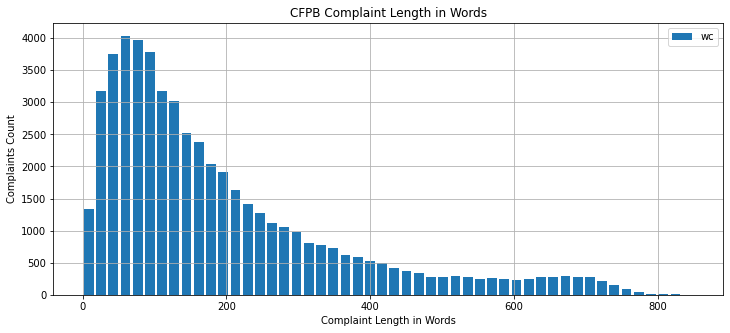

In [12]:
# Histogram: Words
print(f"Total complaints with narrative: {cfpb_train_df.shape[0]:,d}") # ({cwh_notnap:.2f}%)")
title = 'CFPB Complaint Length in Words'
xlabel = 'Complaint Length in Words'
ylabel = 'Complaints Count'

ax = cfpb_train_df.plot(kind="hist", column=['wc'], bins=50, range=(0, 850), 
                        title=title, rwidth=0.8, grid=True, figsize=(12, 5))
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

<hr/>

# <a id="distilbert">DistilBERT Transformer Model</a>


## End-to-end fine-tune: `product` classifier

### DistilBERT
* model_ckpt = "distilbert-base-uncased"
* Model: "tf_distil_bert_for_sequence_classification"
* Total params: 66,961,931

### Notes
* tokenizer with hf.AutoTokenizer.from_pretrained("distilbert-base-uncased")
* End-to-end fine-tuning of hf.TFAutoModelForSequenceClassification("distilbert-base-uncased")
* Training for two epochs with batch size 32

[top](#toc) 

In [13]:
%%time
# Model 
model_ckpt = "distilbert-base-uncased"
batch_size = 32
tokenizer = hf.AutoTokenizer.from_pretrained(model_ckpt)
print(f"tokenizer.model_input_names: {tokenizer.model_input_names}")

def tokenize(batch):
    return tokenizer(batch["consumer_complaint_narrative"], padding=True, truncation=True)

# Tokenize dataset: train, validation, test
cfpb_ds_encoded_dbert = cfpb_ds.map(tokenize, batched=True, batch_size=None)
print(f"Model name: {model_ckpt}, cfpb_ds_encoded_dbert.shape: {cfpb_ds_encoded_dbert.shape}\n")
# cfpb_ds_encoded_dbert["train"]

# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names
random_seed = 287

tf_train_dataset_dbert = cfpb_ds_encoded_dbert["train"].to_tf_dataset(
        columns=tokenizer_columns, label_cols=["pid"], shuffle=True, batch_size=batch_size)
tf_val_dataset_dbert = cfpb_ds_encoded_dbert["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["pid"], shuffle=False, batch_size=batch_size)
tf_test_dataset_dbert = cfpb_ds_encoded_dbert["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["pid"], shuffle=False, batch_size=batch_size)
print(f"Dataset - cfpb_ds.shape: {cfpb_ds.shape}\n")

tokenizer.model_input_names: ['input_ids', 'attention_mask']


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Model name: distilbert-base-uncased, cfpb_ds_encoded_dbert.shape: {'train': (52585, 12), 'validation': (8718, 12), 'test': (5503, 12)}



2023-02-21 16:09:11.221390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset - cfpb_ds.shape: {'train': (52585, 10), 'validation': (8718, 10), 'test': (5503, 10)}

CPU times: user 2min 13s, sys: 7.08 s, total: 2min 20s
Wall time: 36.9 s


In [14]:
# Verify product, issue encodings (pid, iid)
pid_train = cfpb_ds_encoded_dbert["train"]['pid']
print(f" Unique product ids: {np.unique(pid_train)}")

 Unique product ids: [ 0  1  2  3  4  5  6  7  8  9 10]


In [15]:
# Sample run load_model()
model_ckpt = "distilbert-base-uncased"
labels = list(cfpb_product_label2int.values())
num_labels = len(labels)
random_seed = 287 ## SET SEED below for model

tf_model_ldir = "./saved_models/"
tf_model_lfn = "distilbert_cfpb_product_finetune_20220817" # Saved DistilBERT-product model on full CFPB data
model_load_path = os.path.join(tf_model_ldir, tf_model_lfn)

load_model = True  # True to load from model_load_path; False to load vanilla pre-trained model from model_ckpt 
if load_model: 
    tf_model_dbert_p = mu.load_model(num_labels, model_ckpt=None, model_load_path=model_load_path)
else: 
    tf_model_dbert_p = mu.load_model(num_labels, model_ckpt=model_ckpt, model_load_path=None)

tf_model_dbert_p.summary()

Loading model from dir: ./saved_models/distilbert_cfpb_product_finetune_20220817


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./saved_models/distilbert_cfpb_product_finetune_20220817.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  8459      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,961,931
Trainable params: 66,961,931
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Sample run finetune_save_model()
# Save model directory
tf_model_sdir = "./saved_models/"
tf_model_sfn = "distilbert_cfpb_product_finetune_20230219" # Saved DistilBERT-product model ft on full CFPB data
model_save_path = os.path.join(tf_model_sdir, tf_model_sfn)
batch_size = 32
epochs = 1 # 2 or 3
finetune_model = False   # Change to True to fine-tune model
history = mu.finetune_and_save_model(tf_model_dbert_p, tf_train_dataset_dbert, tf_val_dataset_dbert, 
                                     batch_size, epochs, model_save_path, finetune_model=finetune_model)
# tf_model_dbert_p, history

Model not fine-tuned
 - model_ckpt: tf_distil_bert_for_sequence_classification, model.name: tf_distil_bert_for_sequence_classification


## DestilBERT `product` model performance (11 labels)


In [17]:
%%time
# DistilBERT Test scores
model_ckpt = "distilbert-base-uncased"
run_model = False # Set to True to run model 
saved_data_dir = "./saved_data/"
saved_datah5_fn = "cfpb_dbert_test_20221202.h5"
saved_data_path = os.path.join(saved_data_dir, saved_datah5_fn)
y_preds_test_logits_dbert_p = mu.model_run_and_save(tf_model_dbert_p, tf_test_dataset_dbert, 
                                     saved_data_path, ds_name="tf_test_dataset_dbert", run_model=run_model)

y_test = np.array(cfpb_ds_encoded_dbert["test"]["pid"])
y_preds_test = y_preds_test_logits_dbert_p.argmax(-1)
m_test = mu.compute_metrics(y_test, y_preds_test)
(acc, p, f1) = 100*m_test['accuracy'], 100*m_test['precision'], 100*m_test['f1']
print(f"Model: {model_ckpt}\nTest metrics - accuracy: {acc:.2f}, precision: {p:.2f}, F1: {f1:.2f}\n")

Reading saved model output for dataset `tf_test_dataset_dbert`
from saved_data_path: ./saved_data/cfpb_dbert_test_20221202.h5
Loading model output from saved_data_path: ./saved_data/cfpb_dbert_test_20221202.h5
Model: distilbert-base-uncased
Test metrics - accuracy: 87.72, precision: 87.53, F1: 87.56

CPU times: user 42.4 ms, sys: 18 ms, total: 60.4 ms
Wall time: 83.8 ms


In [18]:
# Test classification Report
print(f"Model: {model_ckpt}\nTest - Classification Report")
print(sklearn.metrics.classification_report(y_test, y_preds_test, labels=labels, target_names=cfpb_product_names))

Model: distilbert-base-uncased
Test - Classification Report
                         precision    recall  f1-score   support

Bank account or service       0.92      0.81      0.86       564
          Consumer Loan       0.79      0.76      0.78       368
            Credit card       0.85      0.85      0.85       719
       Credit reporting       0.88      0.92      0.90      1118
        Debt collection       0.85      0.85      0.85      1164
        Money transfers       0.64      0.64      0.64        42
               Mortgage       0.94      0.97      0.95      1278
Other financial service       0.00      0.00      0.00         9
            Payday loan       0.68      0.55      0.61        62
           Prepaid card       0.70      0.76      0.73        34
           Student loan       0.89      0.90      0.89       145

               accuracy                           0.88      5503
              macro avg       0.74      0.73      0.73      5503
           weighted avg     

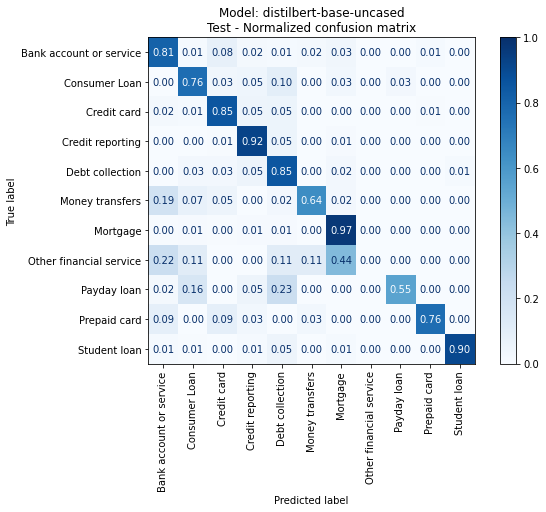

In [19]:
# Test confusion matrix
mu.plot_confusion_matrix(y_preds_test, y_test, cfpb_product_names, f"Model: {model_ckpt}\nTest", figsize=(9,6))

<hr/>

# <a id="finbert">FinBERT Transformer Model</a>

## End-to-end fine-tune: `product` classifier

### FinBERT
* model_ckpt = "ProsusAI/finbert"
* Model: tf_bert_for_sequence_classification (FinBERT)
* Total params: 109,490,699
* FinBERT size - Downloading: 100% 418M/418M [00:09<00:00, 46.7MB/s]

### Notes
* tokenizer with hf.AutoTokenizer.from_pretrained("ProsusAI/finbert")
* End-to-end fine-tuning of hf.TFAutoModelForSequenceClassification("ProsusAI/finbert")
* Training for two epochs with batch size 32

[top](#toc) 

In [20]:
%%time
# FinBERT tokenizer: For paper 
model_ckpt = "ProsusAI/finbert"
batch_size = 32
tokenizer = hf.AutoTokenizer.from_pretrained(model_ckpt)
print(f"Model name: {model_ckpt}, tokenizer.model_input_names: {tokenizer.model_input_names}")

def tokenize(batch):
    return tokenizer(batch["consumer_complaint_narrative"], padding=True, truncation=True)

# Tokenize dataset: train, validation, test
cfpb_ds_encoded_finbert = cfpb_ds.map(tokenize, batched=True, batch_size=None)
print(f"cfpb_ds_encoded_finbert.shape: {cfpb_ds_encoded_finbert.shape}\n")

tokenizer_columns = tokenizer.model_input_names
random_seed = 287

# label vs. label_int columns; 
tf_train_dataset_finbert = cfpb_ds_encoded_finbert["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["pid"], shuffle=True, batch_size=batch_size)
tf_val_dataset_finbert = cfpb_ds_encoded_finbert["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["pid"], shuffle=False, batch_size=batch_size)
tf_test_dataset_finbert = cfpb_ds_encoded_finbert["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["pid"], shuffle=False, batch_size=batch_size)
print(f"Dataset - cfpb_ds.shape: {cfpb_ds.shape}\n")

Model name: ProsusAI/finbert, tokenizer.model_input_names: ['input_ids', 'token_type_ids', 'attention_mask']


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

cfpb_ds_encoded_finbert.shape: {'train': (52585, 13), 'validation': (8718, 13), 'test': (5503, 13)}

Dataset - cfpb_ds.shape: {'train': (52585, 10), 'validation': (8718, 10), 'test': (5503, 10)}

CPU times: user 2min 11s, sys: 5.8 s, total: 2min 17s
Wall time: 34.4 s


In [21]:
# Verify product, issue encodings (pid, iid)
pid_train = cfpb_ds_encoded_finbert["train"]['pid']
print(f" Unique product ids: {np.unique(pid_train)}")

 Unique product ids: [ 0  1  2  3  4  5  6  7  8  9 10]


In [22]:
# Sample run load_model()
# Model checkpoint
model_ckpt = "ProsusAI/finbert"
labels = list(cfpb_product_label2int.values())
num_labels = len(labels)
random_seed = 287 ## SET SEED below for model

tf_model_ldir = "./saved_models/"
tf_model_lfn = "ProsusAI_finbert_cfpb_product_finetune_20220831" # Saved FinBERT-product model on full CFPB data
model_load_path = os.path.join(tf_model_ldir, tf_model_lfn)

load_model = True  # True to load from model_load_path; False to load vanilla pre-trained model from model_ckpt 
if load_model: 
    tf_model_finbert_p = mu.load_model(num_labels, model_ckpt=None, model_load_path=model_load_path)
else: 
    tf_model_finbert_p = mu.load_model(num_labels, model_ckpt=model_ckpt, model_load_path=None)

tf_model_finbert_p.summary()

Loading model from dir: ./saved_models/ProsusAI_finbert_cfpb_product_finetune_20220831


Some layers from the model checkpoint at ./saved_models/ProsusAI_finbert_cfpb_product_finetune_20220831 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_models/ProsusAI_finbert_cfpb_product_finetune_20220831.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without fur

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_57 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  8459      
                                                                 
Total params: 109,490,699
Trainable params: 109,490,699
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Sample run finetune_save_model()
tf_model_sdir = "./saved_models/"
tf_model_sfn = "ProsusAI_finbert_cfpb_product_finetune_20230219" # Save FinBERT-product model ft on full CFPB data
model_save_path = os.path.join(tf_model_sdir, tf_model_sfn)
batch_size = 32
epochs = 1 # 2 or 3
finetune_model = False   # Change to True to fine-tune model
history = mu.finetune_and_save_model(tf_model_finbert_p, tf_train_dataset_dbert, tf_val_dataset_dbert, 
                                     batch_size, epochs, model_save_path, finetune_model=finetune_model)
# tf_model_dbert_p, history

Model not fine-tuned
 - model_ckpt: tf_bert_for_sequence_classification, model.name: tf_bert_for_sequence_classification


## FinBERT `product` model performance (11 labels)


In [24]:
%%time
# FinBERT Test scores
run_model = False # Set to True to run model 
saved_data_dir = "./saved_data/"
saved_datah5_fn = "cfpb_finbert_test_20221125.h5"
saved_data_path = os.path.join(saved_data_dir, saved_datah5_fn)
model_ckpt = "ProsusAI/finbert"
y_preds_test_logits_finbert_p = mu.model_run_and_save(tf_model_finbert_p, tf_test_dataset_finbert, 
    saved_data_path, ds_name="tf_test_dataset_finbert", run_model=run_model)

y_test = np.array(cfpb_ds_encoded_finbert["test"]["pid"])
y_preds_test = y_preds_test_logits_finbert_p.argmax(-1)
m_test = mu.compute_metrics(y_test, y_preds_test)
(acc, p, f1) = 100*m_test['accuracy'], 100*m_test['precision'], 100*m_test['f1']
print(f"Model: {model_ckpt}\nTest metrics - accuracy: {acc:.2f}, precision: {p:.2f}, F1: {f1:.2f}\n")

Reading saved model output for dataset `tf_test_dataset_finbert`
from saved_data_path: ./saved_data/cfpb_finbert_test_20221125.h5
Loading model output from saved_data_path: ./saved_data/cfpb_finbert_test_20221125.h5
Model: ProsusAI/finbert
Test metrics - accuracy: 87.61, precision: 87.55, F1: 87.35

CPU times: user 17.1 ms, sys: 3.16 ms, total: 20.2 ms
Wall time: 20.4 ms


In [25]:
# Test classification Report
print(f"Model: {model_ckpt}\nTest - Classification Report")
print(sklearn.metrics.classification_report(y_test, y_preds_test, labels=labels, target_names=cfpb_product_names))

Model: ProsusAI/finbert
Test - Classification Report
                         precision    recall  f1-score   support

Bank account or service       0.90      0.80      0.85       564
          Consumer Loan       0.84      0.74      0.79       368
            Credit card       0.83      0.90      0.86       719
       Credit reporting       0.87      0.94      0.91      1118
        Debt collection       0.88      0.80      0.84      1164
        Money transfers       0.78      0.60      0.68        42
               Mortgage       0.92      0.97      0.95      1278
Other financial service       0.00      0.00      0.00         9
            Payday loan       0.76      0.47      0.58        62
           Prepaid card       0.55      0.88      0.67        34
           Student loan       0.81      0.92      0.86       145

               accuracy                           0.88      5503
              macro avg       0.74      0.73      0.73      5503
           weighted avg       0.88 

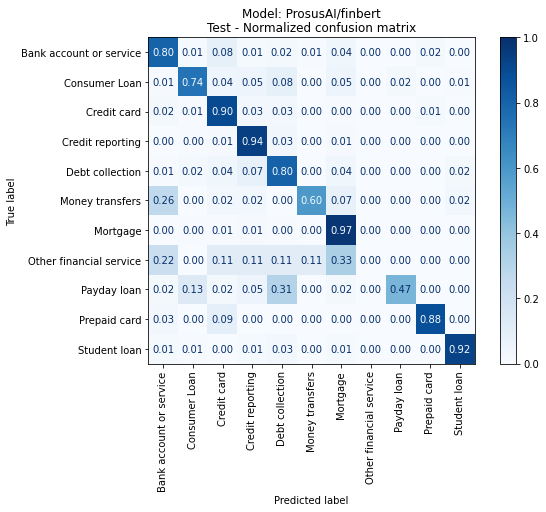

In [26]:
# Test confusion matrix
mu.plot_confusion_matrix(y_preds_test, y_test, cfpb_product_names, f"Model: {model_ckpt}\nTest", figsize=(9,6))

# <a id="performance">Model performance with transformers</a>

Model performance for DistilBERT, FinBERT

* Accuracy, Precision, Recall, F1


[top](#toc) 

In [27]:
# DistilBERT Test scores
model_ckpt = "distilbert-base-uncased"
y_test = np.array(cfpb_ds_encoded_dbert["test"]["pid"])
y_preds_test = y_preds_test_logits_dbert_p.argmax(-1)
m_test = mu.compute_metrics(y_test, y_preds_test)
(acc, p, f1) = 100*m_test['accuracy'], 100*m_test['precision'], 100*m_test['f1']
print(f"Model: {model_ckpt}\nTest metrics - accuracy: {acc:.2f}, precision: {p:.2f}, F1: {f1:.2f}\n")

Model: distilbert-base-uncased
Test metrics - accuracy: 87.72, precision: 87.53, F1: 87.56



In [28]:
# FinBERT Test scores
model_ckpt = "ProsusAI/finbert"
y_test = np.array(cfpb_ds_encoded_finbert["test"]["pid"])
y_preds_test = y_preds_test_logits_finbert_p.argmax(-1)
m_test = mu.compute_metrics(y_test, y_preds_test)
(acc, p, f1) = 100*m_test['accuracy'], 100*m_test['precision'], 100*m_test['f1']
print(f"Model: {model_ckpt}\nTest metrics - accuracy: {acc:.2f}, precision: {p:.2f}, F1: {f1:.2f}\n")

Model: ProsusAI/finbert
Test metrics - accuracy: 87.61, precision: 87.55, F1: 87.35



In [29]:
# EOF